In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np

In [3]:
path = Path('/kaggle/input/planet-understanding-the-amazon-from-space')
path.ls()

[PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/test-tif-v3'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/train-tif-v2'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/test-jpg-v2'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/train-jpg'),
 PosixPath('/kaggle/input/planet-understanding-the-amazon-from-space/train_v2.csv')]

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
tfms = get_transforms(flip_vert=True,max_lighting=0.2,max_zoom=1.05,max_warp=0.0)

In [6]:
np.random.seed(45)
data = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct(0.2)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())   

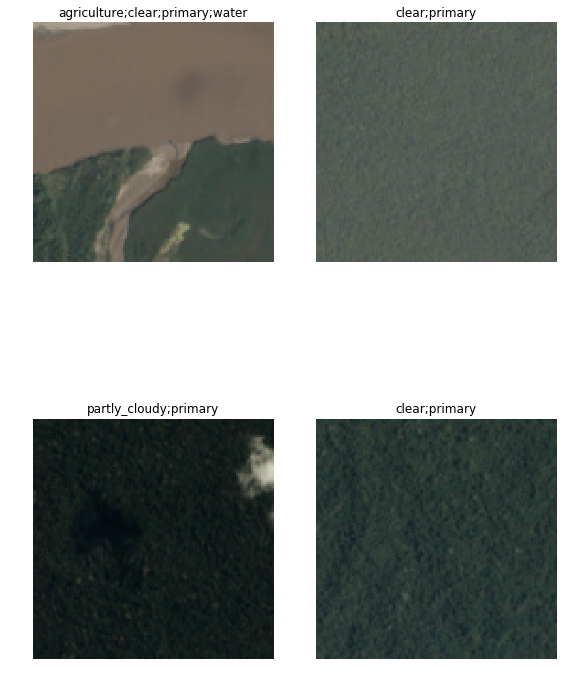

In [7]:
data.show_batch(rows=2,figsize=(8,12))

In [8]:
archtcre = models.resnet50

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data,archtcre,metrics=[acc_02,f_score], model_dir='/tmp/models')

/opt/conda/lib/python3.6/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s] 


In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


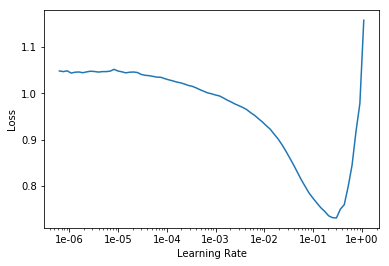

In [11]:
learn.recorder.plot()

In [12]:
lr = 0.01

In [13]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.140643,0.111798,0.943168,0.903078,03:04
1,0.114470,0.099356,0.954598,0.912715,02:38
2,0.104304,0.091255,0.952236,0.919263,02:45
3,0.098103,0.087115,0.955317,0.923985,02:48
4,0.093385,0.085999,0.955586,0.924933,02:41


In [14]:
learn.save('stage-1-rn50')

# Fine-tunning:

In [15]:
learn.unfreeze()

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


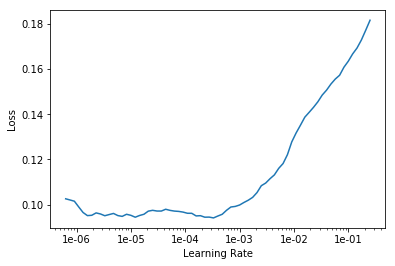

In [17]:
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098223,0.088960,0.953792,0.922055,02:37
1,0.096799,0.090634,0.952781,0.919236,02:37
2,0.091053,0.085605,0.956029,0.924847,02:38
3,0.087586,0.082162,0.957054,0.928563,02:37
4,0.082539,0.081783,0.958290,0.928435,02:37


In [19]:
learn.save('stage-2-rn50')

In [20]:
data = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct(0.2)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=256)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())

In [21]:
learn.data = data
data.train_ds[1][0].shape

torch.Size([3, 256, 256])

In [22]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


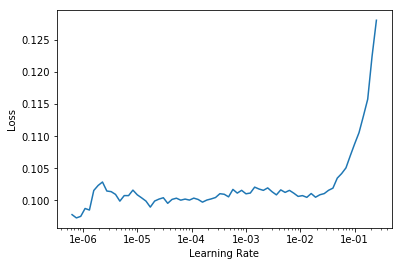

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
lr = 1e-2/2

In [25]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.090787,0.083673,0.957018,0.925540,04:46
1,0.088858,0.083426,0.957592,0.927788,05:12
2,0.086947,0.082470,0.955797,0.927778,05:20
3,0.083560,0.080809,0.959401,0.929283,05:17
4,0.084429,0.079931,0.959576,0.929936,05:16


In [26]:
learn.save('stage-1-256-rn50')

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(5,slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085291,0.084324,0.956342,0.926139,05:36
1,0.085743,0.084300,0.959212,0.927782,05:37
2,0.083023,0.083491,0.958914,0.927392,05:36
3,0.078119,0.081876,0.959365,0.929013,05:34
4,0.075737,0.080486,0.959147,0.930104,05:36


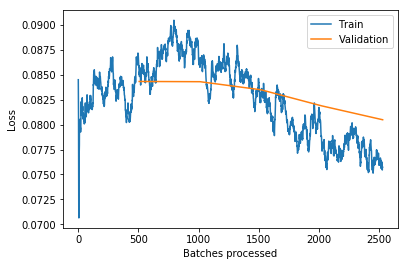

In [29]:
learn.recorder.plot_losses()

In [30]:
learn.save('stage-2-256-rn50')

In [ ]:
learn.export()

In [68]:
pkl_pth=Path('/kaggle/working/export.pkl')
learn.export(pkl_pth)

# Testing

In [51]:
test = ImageList.from_folder(path/'test-jpg-v2').add(ImageList.from_folder(path/'test-jpg-additional'))
print(len(test))

61191


In [69]:
pkl_pth.ls

<bound method <lambda> of PosixPath('/kaggle/working/export.pkl')>

In [71]:
learn = load_learner('/kaggle/working', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [72]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [85]:
labelled_preds[:5]

['agriculture clear cultivation habitation haze primary',
 'agriculture blow_down partly_cloudy primary',
 'clear primary',
 'clear partly_cloudy primary',
 'clear primary']

In [96]:
fnames[:5]

['file_19937', 'test_25942', 'test_5395', 'test_34764', 'test_37003']

In [97]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [98]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
df

,image_name,tags
0,file_19937,agriculture clear cultivation habitation haze ...
1,test_25942,agriculture blow_down partly_cloudy primary
2,test_5395,clear primary
3,test_34764,clear partly_cloudy primary
4,test_37003,clear primary
5,file_1706,clear primary
6,test_13767,agriculture cultivation habitation partly_clou...
7,test_32618,agriculture clear haze primary water
8,test_15993,clear primary
9,file_109,agriculture bare_ground clear habitation prima...


In [99]:
df.head()

,image_name,tags
0,file_19937,agriculture clear cultivation habitation haze ...
1,test_25942,agriculture blow_down partly_cloudy primary
2,test_5395,clear primary
3,test_34764,clear partly_cloudy primary
4,test_37003,clear primary


In [100]:
pth = Path('/kaggle/working')

In [101]:
df.to_csv(pth/'submission.csv', index=False)

In [104]:
from IPython.display import FileLinks
FileLinks('.')

./
  f
  __notebook_source__.ipynb
  folder
  export.pkl
  submission.csv